In [37]:
# import the necessary packages
from __future__ import print_function
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from keras.datasets import mnist
from skimage import exposure
import numpy as np
import pandas as pd
import imutils
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from mlxtend.data import loadlocal_mnist
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
import time
from IPython.display import display

#to ignore warnings in jupyter notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
#read the dataset given in the question
trainData, trainLabels = loadlocal_mnist(
        images_path='data//train-images.idx3-ubyte', 
        labels_path='data/train-labels.idx1-ubyte')
testData, testLabels =loadlocal_mnist(
        images_path='data/t10k-images.idx3-ubyte', 
        labels_path='data/t10k-labels.idx1-ubyte')

In [3]:
#print the shape of each dataframe
print('trainData.shape: ',trainData.shape)       #training data
print('trainLabels.shape: ',trainLabels.shape)   #training labels
print('testData.shape: ',testData.shape)         #testing data
print('testLabels.shape: ',testLabels.shape)     #testing labels

trainData.shape:  (60000, 784)
trainLabels.shape:  (60000,)
testData.shape:  (10000, 784)
testLabels.shape:  (10000,)


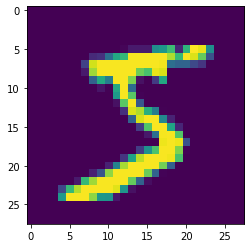

In [4]:
#visualize the digit from the given dataset
plt.imshow(trainData[0].reshape(28,28))

### Let's implement a 1-nearest neighbour classifier on the training dataset and predict the results on the testing dataset and calculate the errors.

**Fit and predict**

In [5]:
#fit and predict the KNN model for n_neighbours=1
model = KNeighborsClassifier(n_neighbors=1)          #create KNN class object
model.fit(trainData, trainLabels)                    #fit model on training dataset
predictions = model.predict(testData)                #prediction

In [11]:
#intermediate table for later use to calculate the errors for each digits 
error_table = pd.DataFrame({'testLabels'  : testLabels,
                            'predictions' : predictions,
                            'correctLabels'     : np.where(testLabels == predictions, 1, 0)})

In [12]:
#final dataframe containing errors for each digits
test_err = pd.DataFrame(error_table.groupby('testLabels').count()).reset_index()
test_err['correctLabels'] = error_table[error_table.correctLabels == 1].groupby('testLabels')['correctLabels'].count()
test_err['Error (%)'] = round((1-(test_err['correctLabels'].divide(test_err['predictions'])))*100,3)    #error calculation

**Error for each digits**

In [13]:
#print the final dataset containing error percentage of predicting each handwritten digits
test_err

,testLabels,predictions,correctLabels,Error (%)
0,0,980,973,0.714
1,1,1135,1129,0.529
2,2,1032,992,3.876
3,3,1010,970,3.960
4,4,982,944,3.870
5,5,892,860,3.587
6,6,958,944,1.461
7,7,1028,992,3.502
8,8,974,920,5.544
9,9,1009,967,4.163


### Conclusion:
* For the model trained on 60000 different hand written digit preprocessed images, the model is successfully detecting 0, 1 and 6 digit with approx 1% error rate.
* The model is facing few challenges in recognizing digit 2, 3, 8 and 9 the most, with approx more than 4% error rate, may be due to the fact of curved features to the top right in each digit to distinguish them all.


### Let's take a step ahead and apply the KNN leave-one-out approach and test values of K from 1 to 20.

In [20]:
loo = LeaveOneOut()  #create leave one out class object for later use
final_ms_error = []  #initialize list to hold final mse detal]ils

#loop through k_values for 1 to 20
for k in range(1,21):
    
    #initialize few lists for later use
    ytests = []
    ypreds = []
    ms_error = []
    
    #split the training dataset into training and testing dataset using leave-one-out approach
    for train_index, test_index in loo.split(pd.DataFrame(trainData).sample(2000,replace=False)):
        X_train, X_test = trainData[train_index], trainData[test_index]        #training and testing data 
        y_train, y_test = trainLabels[train_index], trainLabels[test_index]    #training and testing labels
        
        model = KNeighborsClassifier(n_neighbors=k)                            #create KNN class object
        model.fit(X_train, y_train)                                            #fit model on training dataset
        y_pred = model.predict(X_test)                                         #prediction
        
        ytests += list(y_test)                                                 #store testing dataset
        ypreds += list(y_pred)                                                 #store predictions
        
        ms_error.append(metrics.mean_squared_error(ytests, ypreds))            #calculate MSE for each k values
    
    final_ms_error.append(np.mean(ms_error))                                   #store MSE for each k values for later use

In [21]:
#dataframe containing MSE value for each k values
k_vs_loo_df = pd.DataFrame({'K_value' : k_list,
                            'MSE'     : final_ms_error})
k_vs_loo_df  #display dataframe

,K_value,MSE
0,1,1.508536
1,2,1.619827
2,3,1.697777
3,4,1.604470
4,5,1.820205
5,6,1.985774
6,7,1.911560
7,8,1.757236
8,9,1.675768
9,10,1.665347


**Above table showing MSE values corresponding to their k-values. We can infer the following points from the above table:**
* The best value for K is 1.
* The worst value for k is 19.
* The value of MSE increases with k values.



Text(0.5, 1.0, 'K-value vs. MSE error')

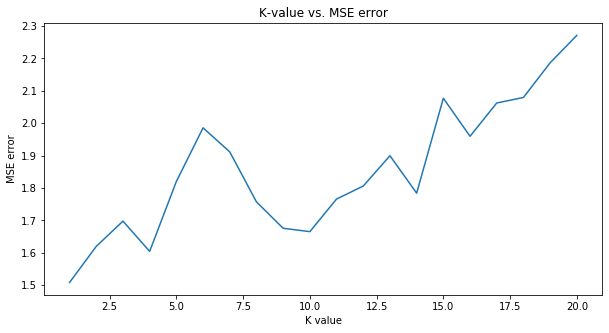

In [22]:
#plot the line plot showing MSE values changes for each K values
plt.figure(figsize=(10,5))                                #modify figure size
plt.plot(k_vs_loo_df.iloc[:,0], k_vs_loo_df.iloc[:,1])    #plot the graph
plt.xlabel('K value')                                     #x-label
plt.ylabel('MSE error')                                   #y-label
plt.title('K-value vs. MSE error')                        #title

**We can infer the following point from the above graph:**
* The overall value of MSE is increased with increase in k nearest neighbour values. Hence, the nature is said to be a linear in upward direction for this specific case.


In [23]:
#fetch the best k value with minimum MSE
min_error_k = np.argmin(final_ms_error)
best_k = min_error_k+1                       #increment with 1 as index starts with 0
print('Best K-value: ',best_k)               #print the best k value

Best K-value:  1


In [24]:
#fit and predict again for the best n_neighbour value calculated above
model = KNeighborsClassifier(n_neighbors=best_k)           #create KNN class object with best n_neighbour value 
model.fit(trainData, trainLabels)                          #fit model on training dataset
predictions = model.predict(testData)                      #prediction

In [25]:
#intermediate table for later use to calculate the errors for each digits 
error_table_2 = pd.DataFrame({'testLabels'  : testLabels,
                            'predictions'   : predictions,
                            'correctLabels' : np.where(testLabels == predictions, 1, 0)})

In [26]:
#final dataframe containing errors for each digits
test_err_2 = pd.DataFrame(error_table_2.groupby('testLabels').count()).reset_index()
test_err_2['correctLabels'] = error_table_2[error_table_2.correctLabels == 1].groupby('testLabels')['correctLabels'].count()
test_err_2['Error (%)'] = round((1-(test_err_2['correctLabels'].divide(test_err_2['predictions'])))*100,3)  #error calculation

#print the final dataset containing error percentage of predicting each handwritten digits
test_err_2

,testLabels,predictions,correctLabels,Error (%)
0,0,980,973,0.714
1,1,1135,1129,0.529
2,2,1032,992,3.876
3,3,1010,970,3.960
4,4,982,944,3.870
5,5,892,860,3.587
6,6,958,944,1.461
7,7,1028,992,3.502
8,8,974,920,5.544
9,9,1009,967,4.163


**We got the similar results as previous as the best k-value we got is 1 after applying leave one out approach.**

### Let's try to downsamples the image by a factor of [2, 4, 8, 16] and repeat the KNN leave-one-out experiment to figure out the MSE errors.

C:\Users\prtk1\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\prtk1\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


,N-value,Total training samples in each LOOCV,Total K-values,Total training time,Best k-value
0,2,999,20,1146.96,4


,K_value,Error
0,1,2.256519
1,2,2.248680
2,3,2.130631
3,4,2.047814
4,5,2.280119
5,6,2.200428
6,7,2.096389
7,8,2.209851
8,9,2.437472
9,10,2.351662


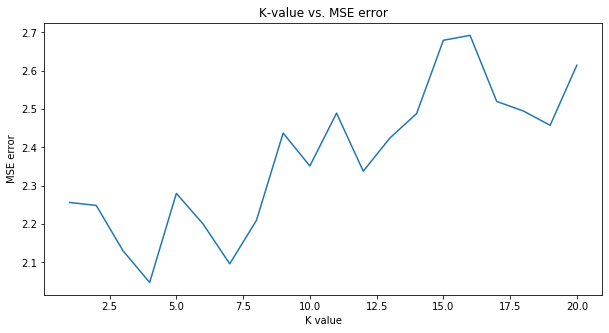

C:\Users\prtk1\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\prtk1\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


,N-value,Total training samples in each LOOCV,Total K-values,Total training time,Best k-value
0,4,999,20,589.1,6


,K_value,Error
0,1,2.980839
1,2,3.377473
2,3,2.550368
3,4,2.593421
4,5,2.600344
5,6,2.502476
6,7,2.840706
7,8,3.030669
8,9,3.156523
9,10,3.164330


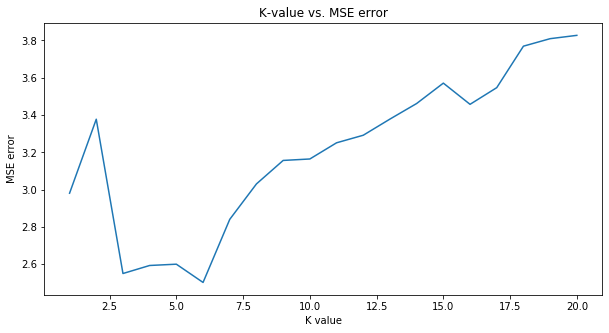

C:\Users\prtk1\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\prtk1\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


,N-value,Total training samples in each LOOCV,Total K-values,Total training time,Best k-value
0,8,999,20,331.05,1


,K_value,Error
0,1,2.532426
1,2,3.297380
2,3,2.941071
3,4,3.042381
4,5,3.113410
5,6,2.868947
6,7,3.010686
7,8,3.500313
8,9,3.362244
9,10,2.956059


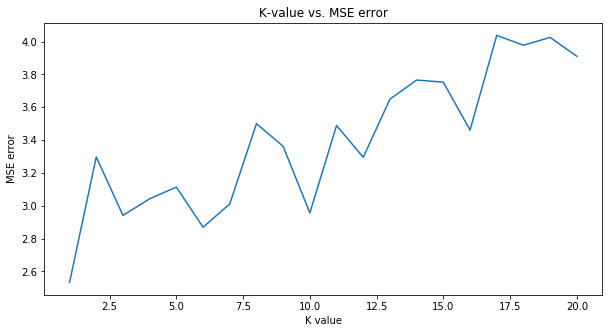

C:\Users\prtk1\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\prtk1\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


,N-value,Total training samples in each LOOCV,Total K-values,Total training time,Best k-value
0,16,999,20,168.75,6


,K_value,Error
0,1,5.427330
1,2,5.036557
2,3,4.882972
3,4,4.822380
4,5,4.932788
5,6,4.449949
6,7,4.565392
7,8,4.655401
8,9,4.957771
9,10,4.668769


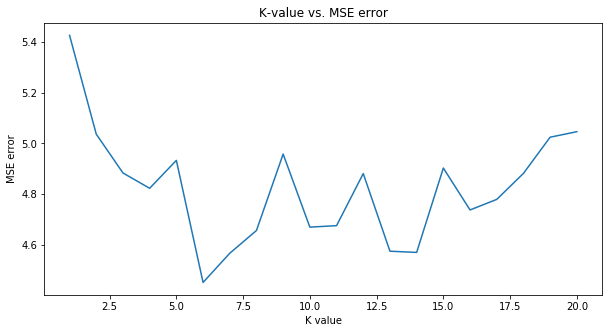

In [33]:
#initialize few lists for later use
best_k = []
sub_trainData_list = []
n = [2, 4, 8, 16]
k_list = range(1,21)

#loop through all n values
for i in n:
    
    #initialize few lists and objects for later use
    final_ms_error = []
    loo = LeaveOneOut()
    sub_trainData = []
    
    #training dataset preparation
    #training and testing dataset preparation
    for j in range(len(trainData)):
        
        #initialize list and variables for later use
        array1=[]
        term=i-1
        
        #loop until all the pixel in each image get parsed
        while term<len(trainData[j]):           
            array1.append(trainData[j][term])   #fetching every nth pixel details
            term=term+i                         #increment with fixed n value
        sub_trainData.append(array1)            #storing every nth pixel details
    
    sub_trainData = np.array(sub_trainData)     #converting from list to numpy array for later use
    sub_trainData_list.append(sub_trainData)    #training dataset
    
    start_time = time.clock()                   #save current time to calculate total time for later use
    
    #loop through each k-values 1 to 20
    for k in k_list:

        #initialize few lists for later use
        ytests = []
        ypreds = []
        ms_error = []

        #split the training dataset into training and testing dataset using leave-one-out approach
        for train_index, test_index in loo.split(pd.DataFrame(trainData).sample(1000,replace=False)):
            X_train, X_test = sub_trainData[train_index], sub_trainData[test_index]    #training and testing data
            y_train, y_test = trainLabels[train_index], trainLabels[test_index]        #training and testing labels 

            model = KNeighborsClassifier(n_neighbors=k)                 #create KNN class object
            model.fit(X_train, y_train)                                 #fit model on training dataset
            y_pred = model.predict(X_test)                              #prediction

            ytests += list(y_test)                                      #store testing dataset
            ypreds += list(y_pred)                                      #store predictions

            ms_error.append(metrics.mean_squared_error(ytests, ypreds)) #calculate MSE for each k values

        final_ms_error.append(np.mean(ms_error))                        #store MSE for each k values for later use
    
    best_k.append(np.argmin(final_ms_error)+1)                          #store best k value for each n values for later use
    
    # dataframe containing various information for each N value like total training sample size for each LOOCV,
    # Total k-values and the best k values among all and total training time.
    stats_df = pd.DataFrame({'N-value'                              : [i],
                             'Total training samples in each LOOCV' : [len(X_train)],
                             'Total K-values'                       : [len(k_list)],
                             'Total training time'                  : [round(time.clock() - start_time,2)],
                             'Best k-value'                         : [np.argmin(final_ms_error)+1]})
    display(stats_df)  #display the stats table
    
    #dataframe containing MSE value for each k values
    k_vs_loo_df = pd.DataFrame({'K_value' : k_list,
                                'Error'   : final_ms_error})
    display(k_vs_loo_df)  #display the dataframe
    
    #plot the line plot showing MSE values changes for each K values
    plt.figure(figsize=(10,5))                                  #modify figure size
    plt.plot(k_vs_loo_df.iloc[:,0], k_vs_loo_df.iloc[:,1])      #plot the graph
    plt.xlabel('K value')                                       #x-label
    plt.ylabel('MSE error')                                     #y-label
    plt.title('K-value vs. MSE error')                          #title
    plt.show()                                                  #display the graph

**We can infer the following points from the above analysis:**
* As we increased the n value, the MSE value also increases.
* For first 3 values of n i.e. [2, 4, 8], the graph seems to be an upward linear fashion, but for the last value of n i.e. [16], the graphs starts with downward trend and later becomes horizontal (with loads of up-down variation).
* As the n increases, the total training time decreases, due to the fact that as we increase the n, the features decreases in the same order, hence less total training time for large n values.
* For each n value, we got the below best k values.

| N value | Best K value |
|------|------------|
| 2 | 4 |
| 4 | 6 |
| 8 | 1 |
| 16 | 6 |

In [40]:
#train and test model for best k values corresponding for each n-values

#initialize lists for later use
n = [2, 4, 8, 16]
final_ms_error = []
ptime = []
ttime=[]

#loop through each n values
for i in range(len(n)):
    
    #initialize lists for later use
    sub_testData = []
    
    #testing dataset preparation
    #loop until all the pixel in each image get parsed
    for j in range(len(testData)):
        array1=[]
        term=n[i]-1
        while term<len(testData[j]):
            array1.append(testData[j][term])           #fetching every nth pixel details
            term=term+n[i]                             #increment with fixed n value
        sub_testData.append(array1)                    #storing every nth pixel details
    
    sub_testData = np.array(sub_testData)              #converting from list to numpy array for later use
    
    #initialize few lists for later use
    ytests = []
    ypreds = []
    ms_error = []
    
    model = KNeighborsClassifier(n_neighbors=best_k[i])          #create KNN class object for best k-value
    start_time = time.clock()                                    #save current time to calculate total training time
    model.fit(sub_trainData_list[i], trainLabels)                #fit model on training dataset
    ttime.append(time.clock() - start_time)                      #storing total training time
    
    start_time = time.clock()                                    #save current time to calculate total prediction time
    y_pred = model.predict(sub_testData)                         #prediction
    ptime.append(time.clock() - start_time)                      #storing total prediction time
    
    ms_error.append(metrics.mean_squared_error(testLabels, y_pred))    #calculate MSE for best k values

    final_ms_error.append(np.mean(ms_error))                           #store MSE for best k values for later use

In [41]:
# dataframe containing various information for each N value like 
# best k-values with corresponding MSe error value, total training and prediction time.
k_vs_loo_df = pd.DataFrame({'N_value'                : n,
                            'Best K_value'           : best_k,
                            'Error'                  : final_ms_error,
                            'Training time (sec)'    : ttime,
                            'Prediction time (sec)'  : ptime})
k_vs_loo_df

,N_value,Best K_value,Error,Training time (sec),Prediction time (sec)
0,2,4,0.6683,16.585498,325.924624
1,4,6,1.1540,12.407819,161.289921
2,8,1,1.3432,10.697109,82.042251
3,16,6,3.0093,8.182866,41.846252


### Conclusion:
* As the value of n increases (downsampling), the training and prediction time decreases due to less feature in case of large n values.
* As the value of n increases (downsampling), the MSE also increases (more bias).

### Let's further explore the smart downsampling function by binning nearby pixels by summing each nXn block in the image where n=[2, 4, 7, 14]

,N-value,Total training samples in each LOOCV,Total K-values,Total training time,Best k-value
0,2,999,20,1727.09,2


,K_value,Error
0,1,1.819058
1,2,1.618867
2,3,1.878089
3,4,1.757349
4,5,1.910671
5,6,1.907683
6,7,1.814293
7,8,1.894607
8,9,2.115213
9,10,2.194068


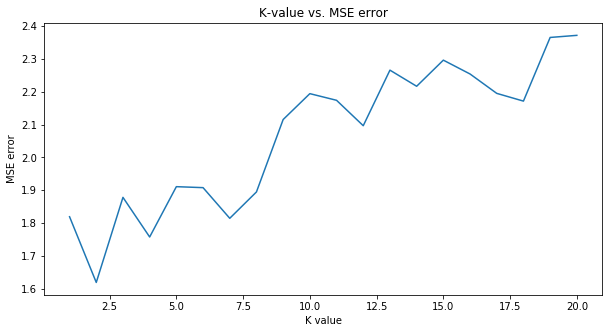

,N-value,Total training samples in each LOOCV,Total K-values,Total training time,Best k-value
0,4,999,20,513.33,2


,K_value,Error
0,1,1.975422
1,2,1.801348
2,3,2.027756
3,4,2.205922
4,5,2.369798
5,6,2.247072
6,7,2.148389
7,8,2.039612
8,9,2.324414
9,10,2.291695


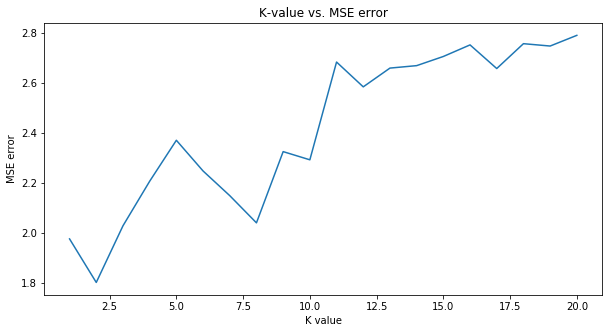

,N-value,Total training samples in each LOOCV,Total K-values,Total training time,Best k-value
0,7,999,20,230.64,4


,K_value,Error
0,1,4.536011
1,2,4.517421
2,3,4.964906
3,4,4.192238
4,5,4.269414
5,6,4.360505
6,7,5.005723
7,8,4.523259
8,9,5.344660
9,10,5.428484


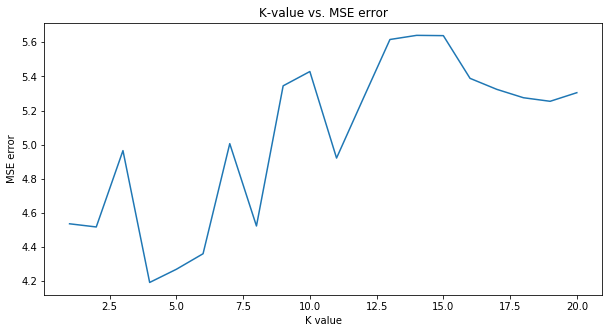

,N-value,Total training samples in each LOOCV,Total K-values,Total training time,Best k-value
0,14,999,20,104.41,20


,K_value,Error
0,1,8.893455
1,2,8.148942
2,3,9.392739
3,4,9.432217
4,5,9.102726
5,6,8.292516
6,7,8.177738
7,8,7.965922
8,9,7.966829
9,10,7.983046


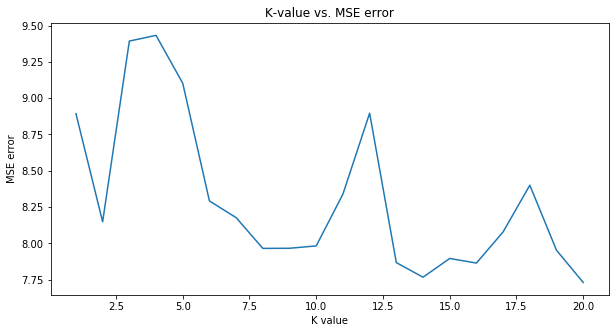

In [82]:
#initialize few lists for later use
best_k = []
arr1_trainData_list = []
num = [2, 4, 7, 14]
k_list = range(1,21)

#reshaping training data pixels to 28*28 for each image
arr = np.reshape(trainData,(60000,28,28)).copy()

#loop through all n values
for n in num:
    
    #data preparation (binning)
    
    #initialize list
    arr1 = []
    
    for i in range(len(arr)):
        arr1.append(arr[i].reshape(int(arr.shape[1]/n), n, int(arr.shape[1]/n), n).sum(-1).sum(1))  #binning
    
    arr1 = np.array(arr1)                                                   #converting from list to numpy array  
    arr1 = arr1.reshape(arr1.shape[0] , arr1.shape[1] * arr1.shape[1])      #reshaping each image for fitting into the model
    arr1_trainData_list.append(arr1)                                        #training dataset
    
    #initialize list and variables for later use
    final_ms_error = []
    loo = LeaveOneOut()
    start_time = time.clock()                        #save current time to calculate total time for later use
    
    #loop through each k-values 1 to 20
    for k in k_list:
        
        #initialize few lists for later use
        ytests = []
        ypreds = []
        ms_error = []

        #split the training dataset into training and testing dataset using leave-one-out approach
        for train_index, test_index in loo.split(pd.DataFrame(trainData).sample(1000,replace=False)):
            X_train, X_test = arr1[train_index], arr1[test_index]                  #training and testing data
            y_train, y_test = trainLabels[train_index], trainLabels[test_index]    #training and testing labels

            model = KNeighborsClassifier(n_neighbors=k)           #create KNN class object
            model.fit(X_train, y_train)                           #fit model on training dataset
            y_pred = model.predict(X_test)                        #prediction

            ytests += list(y_test)                                #store testing dataset
            ypreds += list(y_pred)                                #store predictions

            ms_error.append(metrics.mean_squared_error(ytests, ypreds))  #calculate MSE for each k values

        final_ms_error.append(np.mean(ms_error))                         #store MSE for each k values for later use

    best_k.append(np.argmin(final_ms_error)+1)                           #store best k value for each n values for later use
    
    # dataframe containing various information for each N value like total training sample size for each LOOCV,
    # Total k-values and the best k values among all and total training time.
    stats_df = pd.DataFrame({'N-value'                          : [n],
                         'Total training samples in each LOOCV' : [len(X_train)],
                         'Total K-values'                       : [len(k_list)],
                         'Total training time'                  : [round(time.clock() - start_time,2)],
                         'Best k-value'                         : [np.argmin(final_ms_error)+1]})
    display(stats_df)  #display the stats table
    
    #dataframe containing MSE value for each k values
    k_vs_loo_df = pd.DataFrame({'K_value' : range(1,21),
                                'Error' : final_ms_error})
    display(k_vs_loo_df)  #display the dataframe
    
    #plot the line plot showing MSE values changes for each K values
    plt.figure(figsize=(10,5))                                      #modify figure size
    plt.plot(k_vs_loo_df.iloc[:,0], k_vs_loo_df.iloc[:,1])          #plot the graph
    plt.xlabel('K value')                                           #x-label
    plt.ylabel('MSE error')                                         #y-label
    plt.title('K-value vs. MSE error')                              #title
    plt.show()                                                      #display the graph                                                   

**We can infer the following points from the above analysis:**
* As we increased the n value, the MSE value also increases.
* For first 3 values of n i.e. [2, 4, 8], the graph seems to be an upward linear fashion, but for the last value of n i.e. [16], the graphs shows overall downward linear trend, hence able to distinguish digits more correctly for large k nearest neighnour values.
* As the n increases, the total training time decreases, due to the fact that as we increase the n, the features decreases in the same order, hence less total training time for large n values.
* For each n value, we got the below best k values.

| N value | Best K value |
|------|------------|
| 2 | 2 |
| 4 | 2 |
| 7 | 4 |
| 14 | 20 |

In [86]:
#train and test model for best k values corresponding for each n-values

#initialize lists for later use
num = [2, 4, 7, 14]
final_ms_error = []
ttime = []
ptime = []

#reshaping testing data pixels to 28*28 for each image
arr = np.reshape(testData,(10000,28,28)).copy()

#loop through each n values
for n in range(len(num)):
    
    #testing dataset preparation
    #initialize lists for later use
    arr1_test = []
    
    #loop until all the pixel in each image get parsed
    for i in range(len(arr)):
        arr1_test.append(arr[i].reshape(int(arr.shape[1]/num[n]), num[n], int(arr.shape[1]/num[n]), num[n]).sum(-1).sum(1))  #binning
    
    arr1_test = np.array(arr1_test)     #converting from list to numpy array for later use 
    arr1_test = arr1_test.reshape(arr1_test.shape[0] , arr1_test.shape[1] * arr1_test.shape[1])  #reshaping each image for fitting into the model
    
    #initialize few lists for later use
    ytests = []
    ypreds = []
    ms_error = []

    model = KNeighborsClassifier(n_neighbors=best_k[n])    #create KNN class object for best k-value
    
    start_time = time.clock()                              #save current time to calculate total training time
    model.fit(arr1_trainData_list[n], trainLabels)         #fit model on training dataset
    ttime.append(time.clock() - start_time)                 #storing total training time
    
    start_time = time.clock()                              #save current time to calculate total prediction time
    y_pred = model.predict(arr1_test)                      #prediction
    ptime.append(time.clock() - start_time)                #storing total prediction time
    
    ms_error.append(metrics.mean_squared_error(testLabels, y_pred))  #calculate MSE for best k values

    final_ms_error.append(np.mean(ms_error))                         #store MSE for best k values for later use

In [87]:
# dataframe containing various information for each N value like 
# best k-values with corresponding MSE error value, total training and prediction time.
k_vs_loo_df = pd.DataFrame({'N_value'                : num,
                            'Best K_value'           : best_k,
                            'Error'                  : final_ms_error,
                            'Training time (sec)'    : ttime,
                            'Prediction time (sec)'  : ptime})
k_vs_loo_df  #display the dataframe

,N_value,Best K_value,Error,Training time (sec),Prediction time (sec)
0,2,2,0.6097,27.897041,443.735752
1,4,2,1.0260,2.531836,38.403030
2,7,4,4.3591,0.618693,5.130170
3,14,20,9.7709,0.207796,1.080515


### Conclusion:
* As the value of n increases, the training and prediction time decreases due to less feature in case of large n values.
* As the value of n increases, the MSE also increases (more bias).

### Let's take a step ahead and explore the extreme case of smart downsampling functionality by binning nearby pixels by summing each nXn block in the image where n=[28]

In [68]:
#training dataset preparation
#reshapeing training data pixels to 28*28 for each image
arr = trainData1=np.reshape(trainData,(60000,28,28)).copy()

#initialize list for later use
num = [28]

#loop through all n values
for n in num:
    
    #initialize list
    arr1 = []
    
    #data preparation (binning)
    for i in range(len(arr)):
        arr1.append(arr[i].reshape(int(arr.shape[1]/n), n, int(arr.shape[1]/n), n).sum(-1).sum(1))  #binning
    
arr1 = np.array(arr1)                                                     #converting from list to numpy array  
arr1 = arr1.reshape(arr1.shape[0] , arr1.shape[1] * arr1.shape[1])        #reshaping each image for fitting into the model

In [69]:
#lets visualize the pixel sum for digit 1 and digit 8 to see whether '8' have more dark pixels than a '1' or not
#fetch index for digit 1 and 8
index1 = [i for i, x in enumerate(trainLabels) if x==1]
index8 = [i for i, x in enumerate(trainLabels) if x==8]

#fetch both digit pixel details
res_list1 = [arr1[i][0] for i in index1] 
res_list8 = [arr1[i][0] for i in index8] 
pix_df1 = pd.DataFrame({'pixelsum_digit1': res_list1})
pix_df8 = pd.DataFrame({'pixelsum_digit8': res_list8})

#showing first 5000 image pixel data (summed) for both the digits
pix_df18 = pd.DataFrame({'pixelsum_digit1': res_list1[0:5000],'pixelsum_digit8': res_list8[0:5000]})
pix_df18

,pixelsum_digit1,pixelsum_digit8
0,17135,27106
1,17646,32565
2,10874,28305
3,11622,23182
4,16577,32367
...,...,...
4995,16528,32660
4996,13920,45287
4997,12638,24176
4998,9468,34737


**From the above table we can infer that the pixel of digit 8 are more darker than the pixel of digit 1.**

,N-value,Total training samples in each LOOCV,Total K-values,Total training time,Best k-value
0,28,1999,20,211.81,2


,K_value,Error
0,1,14.619183
1,2,13.931246
2,3,15.313288
3,4,15.613805
4,5,15.789816
5,6,15.256775
6,7,14.476877
7,8,14.518496
8,9,13.949340
9,10,13.986464


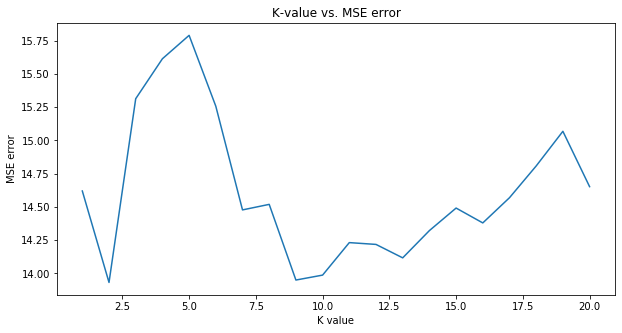

In [79]:
#initialize list
k_list = range(1,21)

#loop through all n values
for i in range(len(num)):
        
    #initialize list and object for later use
    final_ms_error = []
    loo = LeaveOneOut()
    
    start_time = time.clock()     #save current time to calculate total time for later use
    
    #loop through each k-values 1 to 20
    for k in k_list:
        
        #initialize few lists for later use
        ytests = []
        ypreds = []
        ms_error = []
        
        #split the training dataset into training and testing dataset using leave-one-out approach
        for train_index, test_index in loo.split(pd.DataFrame(trainData).sample(2000,replace=False)):
            X_train, X_test = arr1[train_index], arr1[test_index]                  #training and testing data
            y_train, y_test = trainLabels[train_index], trainLabels[test_index]    #training and testing labels

            model = KNeighborsClassifier(n_neighbors=k)         #create KNN class object
            model.fit(X_train, y_train)                         #fit model on training dataset
            y_pred = model.predict(X_test)                      #prediction

            ytests += list(y_test)                              #store testing dataset
            ypreds += list(y_pred)                              #store predictions

            ms_error.append(metrics.mean_squared_error(ytests, ypreds))      #calculate MSE for each k values

        final_ms_error.append(np.mean(ms_error))                             #store MSE for each k values for later use

    best_k = np.argmin(final_ms_error)+1                        #store best k value for each n values for later use
    
    # dataframe containing various information for each N value like total training sample size for each LOOCV,
    # Total k-values and the best k values among all and total training time.
    stats_df = pd.DataFrame({'N-value'                          : [num[i]],
                         'Total training samples in each LOOCV' : [len(X_train)],
                         'Total K-values'                       : [len(k_list)],
                         'Total training time'                  : [round(time.clock() - start_time,2)],
                         'Best k-value'                         : [np.argmin(final_ms_error)+1]})
    display(stats_df)   #display the stats table
    
    #dataframe containing MSE value for each k values
    k_vs_loo_df = pd.DataFrame({'K_value' : k_list,
                                'Error'   : final_ms_error})
    display(k_vs_loo_df)    #display the dataframe
    
    #plot the line plot showing MSE values changes for each K values
    plt.figure(figsize=(10,5))                                     #modify figure size
    plt.plot(k_vs_loo_df.iloc[:,0], k_vs_loo_df.iloc[:,1])         #plot the graph
    plt.xlabel('K value')                                          #x-label
    plt.ylabel('MSE error')                                        #y-label
    plt.title('K-value vs. MSE error')                             #title
    plt.show()                                                     #display the graph

**We can infer the following points from the above analysis:**
* Except k=2, the MSE values seems to be more for lower values of k, and less for larger k values.
* Its hard to detect any linear pattern from the above graph for n=28, because of the fast that we have a single pixel for each image, and various digits share the same portion of range of pixel values, hence, it may hard to classify the digits in the case of binning with n=28.
* For n=28, the total training time is less as compared to all other values of n mentioned above, due to the fact that for this case, we have only 1 feature vector, which needs very less computation intensive, hence, less time required to trail the model.
* For each n value, we got the below best k values.

| N value | Best K value |
|------|------------|
| 28 | 2 |


In [80]:
#train and test model for best k values corresponding for each n-values

#initialize lists for later use
num = [28]
final_ms_error = []
ttime = []
ptime = []

#reshapeing testing data pixels to 28*28 for each image
arr = np.reshape(testData,(10000,28,28)).copy()

#loop through each n values
for n in range(len(num)):
    
    #testing dataset preparation
    #initialize lists for later use
    arr1_test = []

    #loop until all the pixel in each image get parsed
    for i in range(len(arr)):
        arr1_test.append(arr[i].reshape(int(arr.shape[1]/num[n]), num[n], int(arr.shape[1]/num[n]), num[n]).sum(-1).sum(1))  #binning
    
    arr1_test = np.array(arr1_test)                                                                #converting from list to numpy array for later use 
    arr1_test = arr1_test.reshape(arr1_test.shape[0] , arr1_test.shape[1] * arr1_test.shape[1])    #reshaping each image for fitting into the model
    
    #initialize few lists for later use
    ytests = []
    ypreds = []
    ms_error = []

    model = KNeighborsClassifier(n_neighbors=best_k)          #create KNN class object for best k-value
    
    start_time = time.clock()                                 #save current time to calculate total training time
    model.fit(arr1, trainLabels)                              #fit model on training dataset
    ttime.append(time.clock() - start_time)                   #storing total training time
    
    start_time = time.clock()                                 #save current time to calculate total prediction time
    y_pred = model.predict(arr1_test)                         #prediction
    ptime.append(time.clock() - start_time)                   #storing total prediction time
    
    ms_error.append(metrics.mean_squared_error(testLabels, y_pred))    #calculate MSE for best k values

    final_ms_error.append(np.mean(ms_error))                           #store MSE for best k values for later use

In [81]:
# dataframe containing various information for each N value like 
# best k-values with corresponding MSE error value, total training and prediction time.
k_vs_loo_df = pd.DataFrame({'N_value'                : num[0],
                            'Best K_value'           : best_k,
                            'Error'                  : final_ms_error,
                            'Training time (sec)'    : ttime,
                            'Prediction time (sec)'  : ptime})
k_vs_loo_df

,N_value,Best K_value,Error,Training time (sec),Prediction time (sec)
0,28,2,14.8432,0.14711,0.703265


### Conclusion
* For n=28, the MSE error is maximum as compared to other values of n (downsampling) mentioned in the above analysis.
* The training and prediction time is the lowest among all (less than 1 second) because of 1 feature vector for each image.
* For n=28, the best k nearest neighbour values comes out to be 2.

## Feature Extraction based on DCT for Handwritten Digit Recognition 

<p> When it comes to handwritten digit recognition, feature transformation is a pivotal step. To understand more about how feature transformation can be implemented to the handwritten MNIST dataset we turned to the literature to understand the many feature transformation techniques that work best with the given problem statement. </p>

After exploring multiple options available we decided to move forward and implement **Discrete Cosine Transform (DCT)** to our dataset to successfuly extract the most informative features out of the 28 available features. We chose DCT because of the following reasons.
    <ol>
        <li>The transformation is orthogonal.</li>
         <li> Energy is preserved - It means that energy of the spatial sequence is packed into as low frequency coefficients as possible. Which implies, the higher the compaction, lower the number of coefficents to transmit. </li>
        <li>The algorithm is computationally Fast</li>
        <li>The output consists of large number of near zero values for near constant matrices</li>
    </ol>


### Discrete Cosine Transform (DCT) Formula 

<img src="dct_pic.png" alt="Drawing" style="width: 400px;"/>

### Algorithm

<p>DCT encompasses four feature extraction approaches, we decided to implement the first approach for our problem viz. <b> DCT upper left corner(ULC) coefficients</b>. In this approach we apply DCT on every image of the dataset and retain the N most significant coefficients in the upper left corner. </p>

<h4> The diagramtic representation explains the process of feature reduction </h4>

<img src="dct.jfif" alt="Drawing" style="width: 800px;"/>



<h4> Consider the figure given above </h4>
         <ol>
    <li> We pass the 28X28 image for downsizing. The vector length is 786</li>
    <li> The 28X28 image get's downsized to 20X20, wherein the white spaces around the most informative bits are discarded. The vector length now becomes 400</li>
    <li> We then apply DCT to the downsized image vector</li>
    <li> The output image which contains the most significant values in the left top corner(shaded above) is then passed the KNN classifier. </li>
    <li>The process is carried out on the train data and then on the test data. The output with the MSE of each digit is then printed. 
         </ol>

### Practical Implementation

In [98]:
#function to perform data transformation on the training and testing dataset
def cosine_transform_data( n, df_i ):
    c = np.zeros(n)
    d = [x for sublist in df_i for x in sublist]
    for i in range( 0, n ):
        for j in range( 0, n ):
            angle = np.pi * float( 2 * j + 1 ) * float( i ) / 2.0 / float( n )
            c[i] = c[i] + d[j] * np.cos( angle )
        c[i] = c[i] * np.sqrt( 2.0 / float(n) )
    return c

In [99]:
#convert 28*28 pixel data into 20*20 pixel data by removing non-informative pixels (marginal pixels for each image)

#initialize list for later use
trainData20 = []
testData20 = []

#loop through all images in training dataset
for j in trainData.reshape(60000,28,28):
    
    #initialize list
    ar = []
    
    for i in range(4,24):    
        ar.append(j[i][4:-4])     #storing pixels starting from 5th pixel to 24th pixel (inclusive both side)
    trainData20.append(ar)        #storing image pixels

#loop through all images in testing dataset
for j in testData.reshape(10000,28,28):
    
    #initialize list
    ar = []
    
    for i in range(4,24):
        ar.append(j[i][4:-4])     #storing pixels starting from 5th pixel to 24th pixel (inclusive both side)
    testData20.append(ar)         #storing image pixels

In [100]:
#initialize list to hold transformed datasets
cos_df = []
cos_df_test = []

#loop through all images in training dataset
for i in range(len(trainData20[0:1000])):
    d = cosine_transform_data(225,trainData20[i])   #calling transform function
    cos_df.append(d)                                #storing returned value from the function

#loop through all images in testing dataset
for i in range(len(testData20[0:1000])):
    e = cosine_transform_data(225,testData20[i])    #calling transform function
    cos_df_test.append(e)                           #storing returned value from the function
    
cos_df = np.array(cos_df)                           #convert list to numpy array
cos_df_test = np.array(cos_df_test)                 #convert list to numpy array

,Total training samples in each LOOCV,Total K-values,Total training time,Best k-value
0,999,20,669.04,1


,K_value,Error
0,1,2.551117
1,2,2.714343
2,3,2.962608
3,4,2.937084
4,5,2.562475
5,6,2.633567
6,7,2.904683
7,8,3.014958
8,9,3.075429
9,10,3.060306


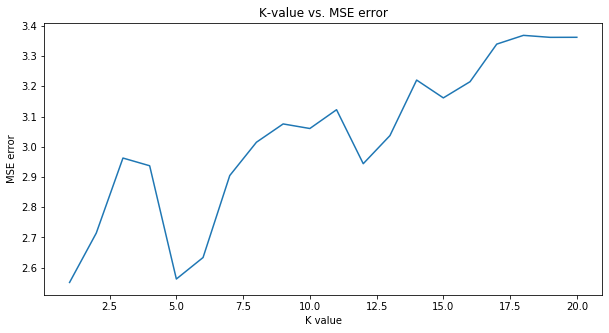

In [65]:
#initialize lists and objects
final_ms_error = []
k_list = range(1,21)
best_k = []
loo = LeaveOneOut()

#save current time to calculate total time for later use
start_time = time.clock()

#loop through each k-values 1 to 20
for k in k_list:
    
    #initialize few lists for later use
    ytests = []
    ypreds = []
    ms_error = []

    #split the training dataset into training and testing dataset using leave-one-out approach
    for train_index, test_index in loo.split(pd.DataFrame(cos_df)):
        X_train, X_test = cos_df[train_index], cos_df[test_index]               #training and testing data
        y_train, y_test = trainLabels[train_index], trainLabels[test_index]     #training and testing labels

        model = KNeighborsClassifier(n_neighbors=k)                             #create KNN class object
        model.fit(X_train, y_train)                                             #fit model on training dataset
        y_pred = model.predict(X_test)                                          #prediction
        
        ytests += list(y_test)                                                  #store testing dataset
        ypreds += list(y_pred)                                                  #store predictions

        ms_error.append(metrics.mean_squared_error(ytests, ypreds))             #calculate MSE for each k values

    final_ms_error.append(np.mean(ms_error))                                    #store MSE for each k values for later use
    
best_k.append(np.argmin(final_ms_error)+1)                                      #store best k value for each n values for later use

# dataframe containing various information for each N value like total training sample size for each LOOCV,
# Total k-values and the best k values among all and total training time.
stats_df = pd.DataFrame({'Total training samples in each LOOCV' : [len(X_train)],
                         'Total K-values'                       : [len(k_list)],
                         'Total training time'                  : [round(time.clock() - start_time,2)],
                         'Best k-value'                         : [best_k[0]]})
display(stats_df)    #display the stats table
    
#dataframe containing MSE value for each k values
k_vs_loo_df = pd.DataFrame({'K_value' : k_list,
                            'Error' : final_ms_error})
display(k_vs_loo_df)  #display the dataframe

#plot the line plot showing MSE values changes for each K values
plt.figure(figsize=(10,5))                                     #modify figure size
plt.plot(k_vs_loo_df.iloc[:,0], k_vs_loo_df.iloc[:,1])         #plot the graph
plt.xlabel('K value')                                          #x-label
plt.ylabel('MSE error')                                        #y-label
plt.title('K-value vs. MSE error')                             #title
plt.show()                                                     #display the graph

**We can infer the following points from the above analysis:**
* The overall pattern of MSE values w.r.t. k-values seems to be an upward direction.
* The best K values based on MSE values comes out to be 1.

In [66]:
#train and test model for best k values corresponding for each n-values

#initialize lists for later use
final_ms_error = []
ttime = []
ptime = []
ms_error = []

model = KNeighborsClassifier(n_neighbors=best_k[0])    #create KNN class object for best k-value

start_time = time.clock()                              #save current time to calculate total training time
model.fit(cos_df, trainLabels[0:1000])                         #fit model on training dataset
ttime.append(time.clock() - start_time)                #storing total training time

start_time = time.clock()                              #save current time to calculate total prediction time
y_pred = model.predict(cos_df_test)                    #prediction
ptime.append(time.clock() - start_time)                #storing total prediction time

ms_error.append(metrics.mean_squared_error(testLabels[0:1000], y_pred))  #calculate MSE for best k values

final_ms_error.append(np.mean(ms_error))                         #store MSE for best k values for later use

In [67]:
# dataframe containing various information for each N value like 
# best k-values with corresponding MSE error value, total training and prediction time.
k_vs_loo_df = pd.DataFrame({'K_value'                : best_k[0],
                            'Error'                  : final_ms_error,
                            'Training time (sec)'    : ttime,
                            'Prediction time (sec)'  : ptime})
k_vs_loo_df

,K_value,Error,Training time (sec),Prediction time (sec)
0,1,3.859,0.037477,0.357017


### Feature Reduced Images for each digit.

**Note:** The image obtained may not be distinguishable with human eye.

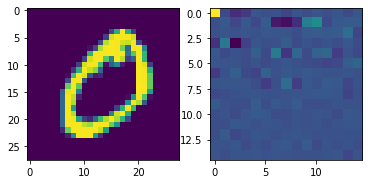

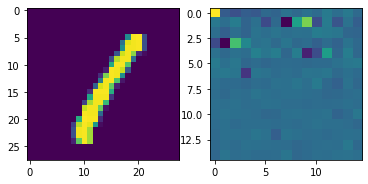

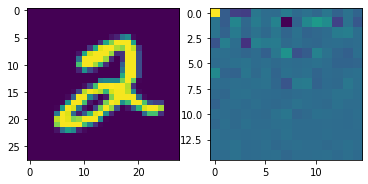

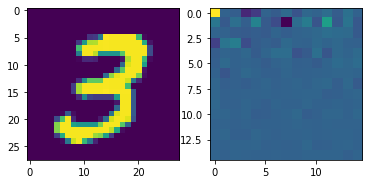

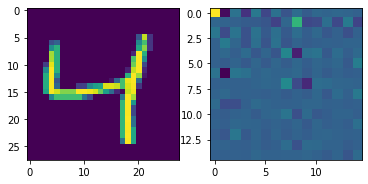

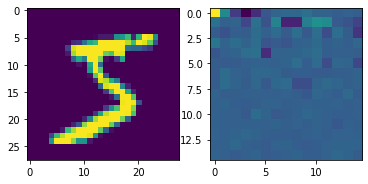

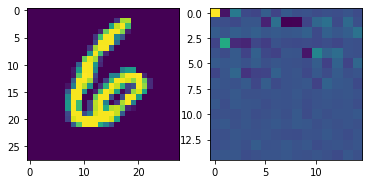

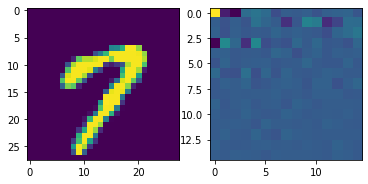

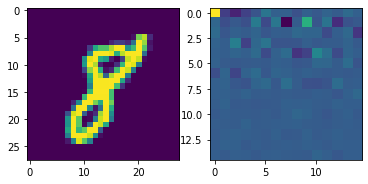

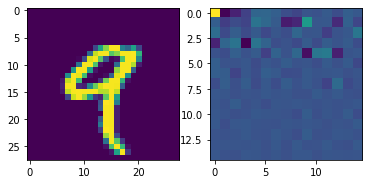

In [97]:
for i in [1, 3, 5, 7, 2, 0, 13, 15, 17, 4]:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.array(trainData[i]).reshape(28,28))
    ax2.imshow(np.array(cos_df[i]).reshape(15,15))
    plt.show()

### Conclusion: 
* The overall time for training as well as testing time is improved significantly (total time: less than 1 second).
* Number of features got reduced, hence, saved loads of computational power and resources.
